# **How do you classify the photos into 2 categories?**
# - Binary Image Classification using CNN -  
If you need to classify the dataset composed of photos that may have 2 features  
(e.g. datasets composed of satellite photos that have 2 features(residential area or nonresidential area)),   
maybe this memo can help you.
  
You can replace your datasets with the sample.  

# **1.Prepare libraries**

In [1]:
import pandas as pd
import numpy as np
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#CNN
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

#predict
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

#other
import warnings
warnings.simplefilter('ignore')

# **2.prepare dataset**  
Separate the photos into 2 different datasets and place them in folders A and B  
You need set your datasets file paths and pixel size

In [5]:
#prepare dataset
real = './data/real/*.jpg'
fake = './data/fake/*.jpg'

list_real = []
list_fake = []

n = 50
m = 50
#A
for x in glob.glob(real):
    img = Image.open(x)
    resize_img = img.resize((n, m))#resize(n,m)
    im  = np.array(resize_img)
    im = im.reshape(-1)
    list_real.append(im/255)
#B  
for x in glob.glob(fake):
    img = Image.open(x)
    resize_img = img.resize((n, m))#resize(n,m)
    im  = np.array(resize_img)
    im = im.reshape(-1)
    list_fake.append(im/255)

In [7]:
#make dataframe
df_A = pd.DataFrame(list_real)
df_A['label'] = np.zeros(len(list_real))
df_B = pd.DataFrame(list_fake)
df_B['label'] = np.ones(len(list_fake))
df =  pd.concat([df_A, df_B], axis=0).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,label
0,0.588235,0.517647,0.541176,0.611765,0.631373,0.635294,0.607843,0.623529,0.627451,0.607843,...,0.435294,0.286275,0.309804,0.243137,0.098039,0.121569,0.321569,0.137255,0.168627,0.0
1,0.368627,0.364706,0.278431,0.364706,0.368627,0.282353,0.368627,0.376471,0.290196,0.364706,...,0.176471,0.121569,0.133333,0.172549,0.121569,0.129412,0.160784,0.117647,0.113725,0.0
2,0.760784,0.729412,0.709804,0.741176,0.701961,0.662745,0.592157,0.521569,0.462745,0.678431,...,0.360784,0.337255,0.313725,0.372549,0.286275,0.301961,0.321569,0.345098,0.337255,0.0
3,0.513725,0.592157,0.647059,0.509804,0.588235,0.639216,0.490196,0.576471,0.639216,0.474510,...,0.023529,0.039216,0.086275,0.019608,0.039216,0.082353,0.023529,0.035294,0.082353,0.0
4,0.223529,0.172549,0.145098,0.235294,0.184314,0.149020,0.243137,0.188235,0.156863,0.254902,...,0.686275,0.596078,0.462745,0.674510,0.588235,0.458824,0.662745,0.588235,0.450980,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,0.360784,0.364706,0.333333,0.364706,0.368627,0.333333,0.372549,0.372549,0.341176,0.388235,...,0.388235,0.321569,0.282353,0.431373,0.360784,0.325490,0.478431,0.458824,0.415686,1.0
3612,0.525490,0.403922,0.349020,0.537255,0.403922,0.360784,0.521569,0.380392,0.345098,0.525490,...,0.486275,0.337255,0.278431,0.482353,0.349020,0.286275,0.490196,0.380392,0.317647,1.0
3613,0.482353,0.419608,0.419608,0.431373,0.360784,0.368627,0.462745,0.388235,0.403922,0.482353,...,0.505882,0.450980,0.443137,0.529412,0.478431,0.466667,0.525490,0.482353,0.470588,1.0
3614,0.537255,0.407843,0.360784,0.537255,0.400000,0.356863,0.529412,0.392157,0.345098,0.541176,...,0.658824,0.431373,0.360784,0.631373,0.403922,0.333333,0.666667,0.466667,0.392157,1.0


In [8]:
#make train-valid dataset
X = df.drop('label',axis=1) # Features
y = df.label #Objective

X_ = X.values.reshape(-1, m, n, 3)#(m,n), not (n,m)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, stratify=y, test_size=0.3)

# **3. study CNN model**  
You can change the parameters used in the model

In [10]:
##model_CNN
model = keras.Sequential([
    layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'Same', activation ='relu', input_shape = (m,n,3)),#(m,n), not (n,m)
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters = 128, kernel_size = (2,2), padding = 'Same', activation ='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters = 256, kernel_size = (2,2), padding = 'Same', activation ='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)


Epoch 1/20
31/31 [==============================] - 5s 139ms/step - loss: 0.0609 - acc: 0.9918 - val_loss: 0.1105 - val_acc: 0.9982
Epoch 2/20
31/31 [==============================] - 4s 127ms/step - loss: 0.0135 - acc: 0.9988 - val_loss: 0.0336 - val_acc: 0.9982
Epoch 3/20
31/31 [==============================] - 4s 137ms/step - loss: 0.0103 - acc: 0.9988 - val_loss: 0.0285 - val_acc: 0.9982
Epoch 4/20
31/31 [==============================] - 4s 140ms/step - loss: 0.0123 - acc: 0.9988 - val_loss: 0.0146 - val_acc: 0.9982
Epoch 5/20
31/31 [==============================] - 4s 136ms/step - loss: 0.0112 - acc: 0.9988 - val_loss: 0.0222 - val_acc: 0.9982
Epoch 6/20
31/31 [==============================] - 4s 129ms/step - loss: 0.0070 - acc: 0.9988 - val_loss: 0.0110 - val_acc: 0.9982
Epoch 7/20
31/31 [==============================] - 4s 131ms/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.0505 - val_acc: 0.9982
Epoch 8/20
31/31 [==============================] - 4s 137ms/step - loss: 0.

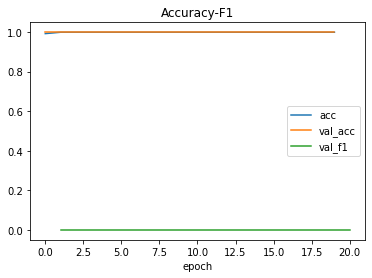

34/34 [==============================] - 1s 15ms/step
valid_f1-score-best: 0.0
valid_confusion_matrix-best:
 [[1083    0]
 [   2    0]]


In [11]:

#f1-score_callback
class F1Callback(Callback):
    def __init__(self, model, X_val, y_val):
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.f1s = []

    def on_epoch_end(self, epoch, logs):
        pred = self.model.predict(self.X_val)
        f1_val = f1_score(self.y_val, np.round(pred))
        self.f1s.append(f1_val)
f1cb = F1Callback(model, X_valid, y_valid)

#early_stop
early_stopping = EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

#checkpoint
cp = ModelCheckpoint("weights.hdf5", monitor="val_loss", verbose=0,
                     save_best_only=True, save_weights_only=True)

#Data_Augmentation
datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True
)

batch_size=80

#study
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=20,
    callbacks=[f1cb, early_stopping, cp],
    verbose=1
)

#plot
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['acc', 'val_acc']].plot(title="Accuracy-F1")
plt.plot(np.arange(len(f1cb.f1s)) + 1, np.array(f1cb.f1s), label="val_f1")
plt.legend()
plt.xlabel("epoch")
plt.show()

#predict validation data with best
model.load_weights('./weights.hdf5')
y_pred = model.predict(X_valid).round()
#valid_score
print("valid_f1-score-best:", f1_score(y_valid, y_pred))
print("valid_confusion_matrix-best:\n", confusion_matrix(y_valid, y_pred))

# **4. save model**  
You need to prepare test dataset with the same way as train-valid dataset

In [16]:
model.save("model.h5")